In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv3D, BatchNormalization, concatenate,Conv3D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv('smart_traffic_management_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

label_encoders = {}
for col in ['weather_condition', 'signal_status']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

features = df.drop(columns=['timestamp', 'traffic_volume'])
target = df['traffic_volume'].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

In [3]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

In [4]:
data_scaled = np.hstack((X_scaled, y_scaled))
SEQ_LEN = 10
X_seq, y_seq = create_sequences(data_scaled, SEQ_LEN)

In [5]:
X_unet = X_seq.reshape((X_seq.shape[0], SEQ_LEN, 10, 1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_unet, y_seq, test_size=0.2, random_state=42)

inputs = Input(shape=(SEQ_LEN, 10, 1, 1))

In [6]:
e1 = ConvLSTM2D(32, (3, 1), padding='same', return_sequences=True, activation='relu')(inputs)
e1 = BatchNormalization()(e1)

e2 = ConvLSTM2D(64, (3, 1), padding='same', return_sequences=True, activation='relu')(e1)
e2 = BatchNormalization()(e2)

In [7]:
bottleneck = ConvLSTM2D(128, (3, 1), padding='same', return_sequences=True, activation='relu')(e2)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = Dropout(0.3)(bottleneck)

In [8]:
d1 = ConvLSTM2D(64, (3, 1), padding='same', return_sequences=True, activation='relu')(bottleneck)
d1 = BatchNormalization()(d1)
d1 = concatenate([d1, e2])

d2 = ConvLSTM2D(32, (3, 1), padding='same', return_sequences=True, activation='relu')(d1)
d2 = BatchNormalization()(d2)
d2 = concatenate([d2, e1])

In [9]:
d3 = Conv3D(1, (1, 1, 1), activation='linear')(d2)
x_flat = Flatten()(d3)
x_dense = Dense(32, activation='relu')(x_flat)
x_dense = Dropout(0.2)(x_dense)
output = Dense(1, activation='linear')(x_dense)

In [10]:
model_unet = Model(inputs, output)
model_unet.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)

history = model_unet.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.5290 - mae: 0.5392 - val_loss: 0.2419 - val_mae: 0.4188 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1099 - mae: 0.2758 - val_loss: 0.2085 - val_mae: 0.3859 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0989 - mae: 0.2603 - val_loss: 0.2133 - val_mae: 0.3907 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0920 - mae: 0.2579 - val_loss: 0.2070 - val_mae: 0.3843 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0915 - mae: 0.2555 - val_loss: 0.2141 - val_mae: 0.3914 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0914 - mae: 0.2564 - val_loss: 0.1993 - val_mae: 0.3764 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0873 - mae: 0.2491 - val_loss: 0.1987 - val_mae: 0.3750 - learning_rate: 0.0010
Epoc

In [11]:
y_pred = model_unet.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


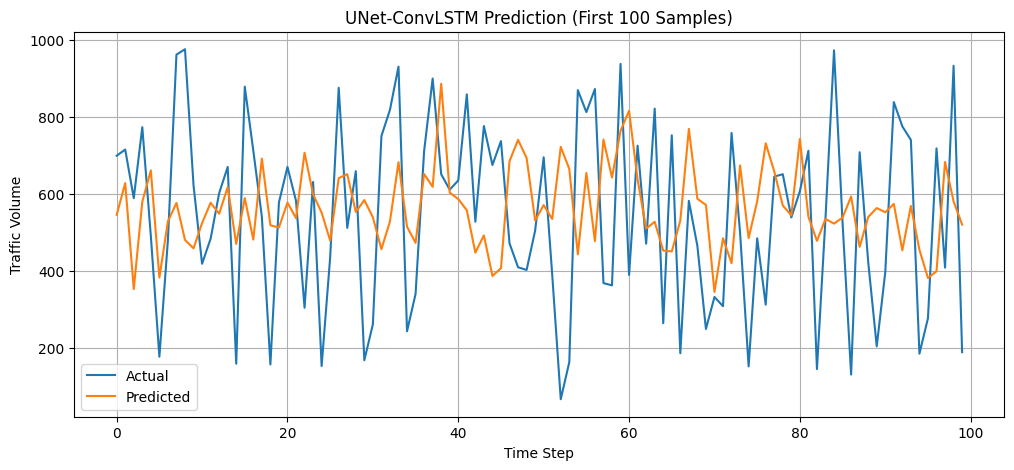

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted')
plt.title("UNet-ConvLSTM Prediction (First 100 Samples)")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()